In [1]:
!ls ../data/raw

In [2]:
%load_ext autoreload
%autoreload 2
import data_tools

In [3]:
import lightgbm as lgb
import pandas as pd
import numpy as np

In [4]:
LOCAL = True
if LOCAL:
    fpath = "../data/raw/"

In [5]:
df = pd.read_csv(
    f"{fpath}train.csv",
    header=None,
    dtype='category'
)

In [6]:
df.shape

(862, 2961)

In [7]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2951,2952,2953,2954,2955,2956,2957,2958,2959,2960
0,P239476,Non-Essential,No,No,No,No,No,No,No,No,...,No,No,Yes,No,No,Yes,No,No,nucleus,0
1,P234427,Non-Essential,No,No,No,No,No,No,No,No,...,No,No,No,No,No,Yes,No,No,nucleus,0
2,P234429,Non-Essential,No,No,No,Yes,No,No,No,No,...,No,No,No,No,No,No,No,No,nucleus,0
3,P234430,Non-Essential,No,No,No,No,No,No,No,No,...,No,Yes,No,No,No,Yes,No,No,nucleus,0
4,P239467,Essential,No,No,No,No,No,No,No,No,...,No,No,No,No,No,Yes,No,No,nucleus,0


In [8]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,2951,2952,2953,2954,2955,2956,2957,2958,2959,2960
count,862,862,862,862,862,862,862,862,862,862,...,862,862,862,862,862,862,862,862,862,862
unique,862,4,2,1,2,2,2,1,2,2,...,2,2,2,2,2,2,2,1,15,15
top,P236152,Non-Essential,No,No,No,No,No,No,No,No,...,No,No,No,No,No,No,No,No,nucleus,0
freq,1,528,861,862,861,823,859,862,832,860,...,819,838,690,693,798,591,824,862,366,366


In [9]:
# Replace missing values (? marks) with nan
df = df.replace("?", np.nan)
any(df.isin(["-"]).any(axis=1))

False

In [10]:
df[2960].value_counts()

0     366
1     192
2      69
3      58
5      43
4      43
6      35
7      18
8      17
9      10
10      4
11      3
12      2
14      1
13      1
Name: 2960, dtype: int64

LOL classes 13 and 14 only have one training instance... may have to force them into training datasets.

## Analysis of Features
* What are the data types?

In [11]:
nuniques = df.nunique()

In [12]:
len(nuniques[nuniques < 3])  # Number of variables with 2 unique values (likely boolean)

2409

In [13]:
nuniques > 100

0        True
1       False
2       False
3       False
4       False
        ...  
2956    False
2957    False
2958    False
2959    False
2960    False
Length: 2961, dtype: bool

In [14]:
len(nuniques)

2961

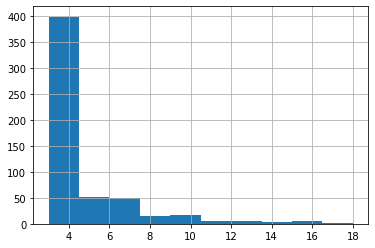

In [15]:
# Variables with number of unique values between 2 and 800
nuniques[(2 < nuniques) & (nuniques  < 800)].hist();

In [16]:
nuniques.sort_values(ascending=False)

0       862
1114     18
1652     17
444      16
449      16
       ... 
2648      0
2647      0
2646      0
2645      0
2741      0
Length: 2961, dtype: int64

Appears that the majority of features boolean, many are categorical, some may be continuous? Have yet to see any that are.

Also worth noting that the column names are integers, not strings.

## Protein Interactions File

In [17]:
interaction_colnames = ['protein1', 'protein2', 'type', 'strength']
df2 = pd.read_csv(
    "../data/raw/protein_interactions.csv",
    header=None,
    names=interaction_colnames,
    dtype={
        'type' : 'category',
    }
)
df2.shape

(910, 4)

In [18]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   protein1  910 non-null    object  
 1   protein2  910 non-null    object  
 2   type      910 non-null    category
 3   strength  910 non-null    object  
dtypes: category(1), object(3)
memory usage: 22.4+ KB


In [19]:
# The strength values have a random period at
# the end of the values preventing it from being parsed as numeric
df2['strength'] = df2['strength'].str.rstrip('.').replace("?", np.nan)
df2['strength'] = pd.to_numeric(df2['strength'].str.rstrip('.'))

In [20]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   protein1  910 non-null    object  
 1   protein2  910 non-null    object  
 2   type      910 non-null    category
 3   strength  871 non-null    float64 
dtypes: category(1), float64(1), object(2)
memory usage: 22.4+ KB


## Data Processing
* Missing Values
* Categoricals? Deal with it if the model requires it!

In [21]:
field_descriptions_fpath = data_tools.field_descriptions_fpath
fields = data_tools.parse_field_descriptions(field_descriptions_fpath)
fields

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,protein,label.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,essential,Essential,Non-Essential,Ambiguous-Essential.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,class actin related proteins,Yes,No.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,class actins,Yes,No.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,class adaptins,Yes,No.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2956,function transcription,Yes,No.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2957,function transport facilitation,Yes,No.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2958,function transposable elements viral and plasm...,:,Yes,No.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2959,localization,cell wall,cytoplasm,cytoskeleton,endosome,ER,extracellular,golgi,integral membrane,lipid particles,mitochondria,nucleus,peroxisome,plasma membrane,transport vesicles,vacuole.:,NaN


# Saving output

In [24]:
df.to_pickle("../data/intermediate/data.pkl")